In [17]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [3]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 1 / 30.

In [4]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,10,0,0,-0.138828,-0.138838
1,11,0,0,-1.804539,-1.796516
2,10,1,0,-0.102298,-0.102305
3,11,1,4,-2.582745,-2.589395
4,10,2,0,-0.080524,-0.080530


In [5]:
gpm.Xframe.head()

,X0,X1,X2
0,1.749200,0.083333,0.000000
1,0.716926,0.092861,0.000000
2,1.386294,1.395833,3.461310
3,0.750306,0.349570,0.720427
4,1.609438,2.033333,2.786310


# Plot inferred categories as matrix

In [6]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
print xi.shape

(100001, 5)


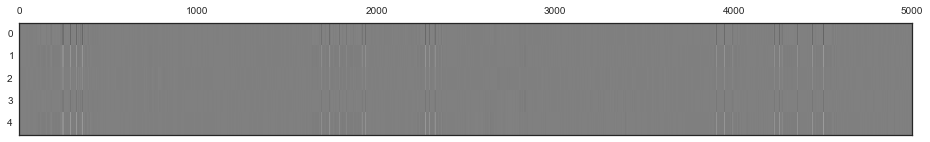

In [10]:
matshow(xi[:5000].T, vmin=0, vmax=1)

# Posteriors for effects

## Baselines

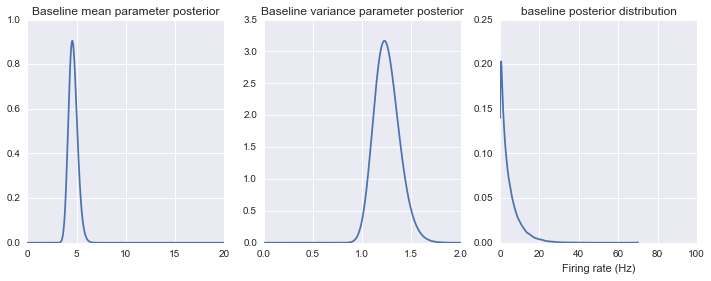

In [19]:
plt.figure(figsize=(12, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 2, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

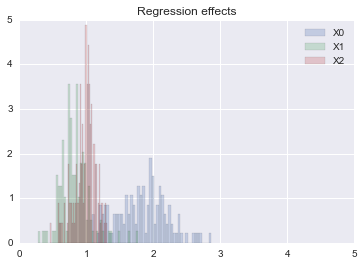

In [25]:
inferred_means = gpm.nodes['fr_regressors'].expected_x()
R = inferred_means.shape[1]
for r in xrange(R):
    plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
plt.title('Regression effects');
plt.legend()
plt.ylim(0, 5);
plt.xlim(0, 5);

## Latent Categories

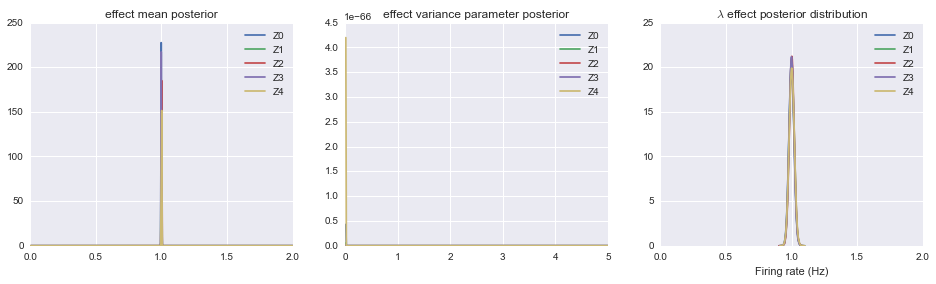

In [37]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

K = th.post_shape.shape[0]

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 2);

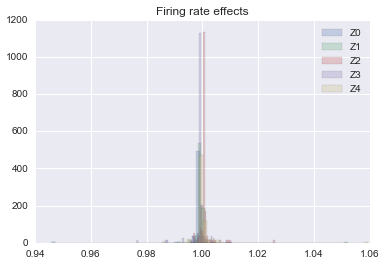

In [38]:
inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');

## Overdispersion

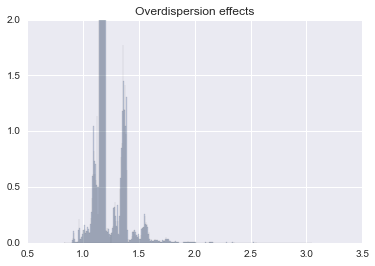

In [34]:
inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
plt.title('Overdispersion effects');
plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [8]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

/Users/jmxp/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [9]:
etho.head()

,movieId,frameTime,frameNumber,ethoCameraLabel,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,...,ethoCharge,ethoChase,ethoFlee,ethoThreaten,ethoMountedThreaten,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay
0,1,0.0000,0,holding,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.0333,1,holding,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0.0667,2,holding,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0.1000,3,holding,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0.1333,4,holding,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})

In [11]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, df, how='right')
edf.columns

Index([u'movie', u'frameTime', u'frame', u'ethoCameraLabel', u'ethoCameraLevel', u'ethoCameraHolding', u'ethoCameraZoomingIn', u'ethoCameraZoomingOut', u'ethoCameraTracking', u'ethoCameraPanning', u'ethoCameraSlewing', u'ethoRoughCountLabel', u'ethoRoughCountLevel', u'ethoCountNone', u'ethoLeast1', u'ethoLeast2', u'ethoLeast3', u'ethoLeast6', u'ethoLeast11', u'ethoHumanVisible', u'ethoFaceLabel', u'ethoFaceViewLevel', u'ethoFaceNone', u'ethoFaceVisible', u'ethoFaceProminent', u'ethoFaceDirect', u'ethoFaceEyeContact', u'ethoGenitalsLabel', u'ethoGenitalsViewLevel', u'ethoGenitalsNone', u'ethoGenitalsVisible', u'ethoGenitalsProminent', u'ethoGenitalsMale', u'ethoGenitalsFemale', u'ethoGenitalsBoth', u'ethoForageLabel', u'ethoForageLevel', u'ethoForage', u'ethoMassForage', u'ethoDrink', u'ethoSearch', u'ethoGraspFood', u'ethoHoldFood', u'ethoHoldInMouth', u'ethoManipulateFood', u'ethoIngestFood', u'ethoIngestFromGroom', u'ethoChew', u'ethoRetrieveFromPouch', u'ethoHeave', u'ethoAllogroom'

In [12]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['movie', 'frameTime', 'frame', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoRoughCountLabel'], axis=1)

In [13]:
edf.head()

,ethoCameraLevel,ethoCameraHolding,ethoCameraZoomingIn,ethoCameraZoomingOut,ethoCameraTracking,ethoCameraPanning,ethoCameraSlewing,ethoRoughCountLevel,ethoCountNone,ethoLeast1,...,ethoSubmit,ethoDisplace,ethoLeanAway,ethoAvoid,ethoBranchDisplay,0,1,2,3,4
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0.962218,0.564181,0.523433,0.498135,0.481726
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0.994416,0.194662,0.245615,0.281497,0.306595
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0.997607,0.347369,0.348749,0.349896,0.351049
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0.998959,0.353127,0.352289,0.352068,0.352369
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0.999533,0.296414,0.315153,0.327510,0.336123


# View results:

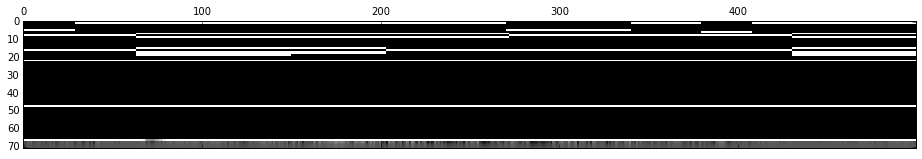

In [14]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
matshow(edf.iloc[500:1000, :].values.T, vmin=0, vmax=1)

## Correlation analysis:

The idea is to compute a correlation matrix between inferred and hand-labeled ethogram categories. To do so, we z-score the regressor values.

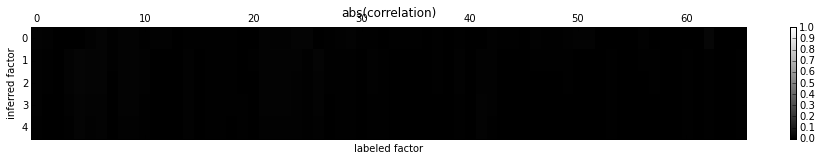

In [15]:
# compute z-scored regressors
sd = edf.std()
sd[sd == 0] = 1
zdf = (edf - edf.mean()) / sd
labeled = zdf.iloc[:, :-5].values
inferred = zdf.iloc[:, -5:].values

# compute correlation as dot product between standardized regressors
T = labeled.shape[0]
corr = inferred.T.dot(labeled) / T

# plot results
matshow(np.abs(corr), vmin=0, vmax=1)
plt.xlabel('labeled factor');
plt.ylabel('inferred factor');
plt.title('abs(correlation)');
plt.colorbar();

As a different approach, try just computing a correlation matrix between unnormalized regressors:

In [16]:
# np.corrcoef computes correlation coefficients between all pairs of variables in first two arguments
aa = np.corrcoef(edf.iloc[:, -5:], edf.iloc[:, :-5], rowvar=0)

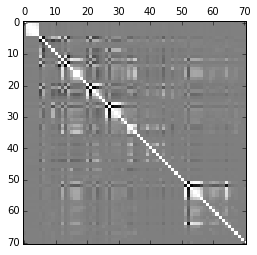

In [17]:
matshow(aa, vmin=-1, vmax=1)

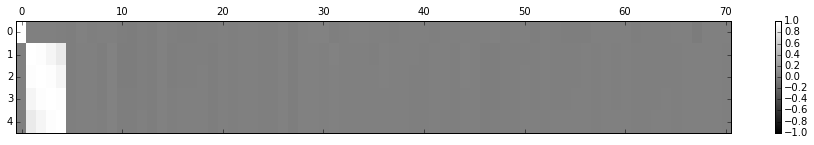

In [18]:
matshow(aa[:5, :], vmin=-1, vmax=1)
plt.colorbar();

In [19]:
aa.shape

(71, 71)

In [20]:
aa[:5, 5:]

array([[ -1.44871900e-02,   9.98229049e-03,  -1.43720629e-03,
          1.39536234e-03,   3.86865893e-03,  -1.04856302e-02,
         -1.57635571e-02,  -5.97929976e-03,  -1.51753535e-02,
          1.51753535e-02,  -7.56410409e-03,  -8.22891648e-03,
         -8.22891648e-03,  -2.93385029e-03,  -4.93108585e-03,
          5.18587047e-03,  -5.28506812e-03,   5.28506812e-03,
          6.57589661e-03,  -3.85368131e-04,  -3.15339617e-03,
          1.30027257e-02,  -9.21206981e-03,   9.21206981e-03,
          1.57785160e-02,   1.60250328e-02,  -2.62668623e-04,
          4.04241667e-03,   1.06303332e-02,   1.19597125e-02,
          4.17047116e-03,   5.36434929e-03,  -2.26537591e-04,
          4.29137285e-03,   7.54511085e-03,   4.36367182e-03,
         -2.62594756e-03,   6.69769131e-03,   2.82559469e-03,
          6.78866122e-03,   2.11796999e-03,   9.95098000e-04,
          7.88353317e-03,  -6.03422319e-03,   4.94847363e-03,
          3.78278064e-03,  -1.15706187e-02,   6.14180656e-03,
        